# Pytorch Workflow Fundamentals

1. Prepare data (Tensors)
2. Building Model (loss function and optimizer + building training loop)
3. Training
4. Inference
5. Saving and Loading model
6. Putting it all together
<!-- 5. (Evaluation and Iterative Improvement) -->



In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu117'

### 1. Prepare Data

In [2]:
weight = 0.7
bias = 0.3

# data creation
# X = torch.randn(100, 1) * 10
X = torch.arange(0,1,0.02).unsqueeze(dim=1) # unsqueezed to make tensor otherwise it would be vector
y= weight *X + bias
print(X[:10].squeeze(dim=1),"\n", y[:10].squeeze(dim=1)) # if no unsqueeze used then it would be vector
X[:10] ,y[:10] 


tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800]) 
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
        0.4260])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# Data splitting
train_size = int(0.8 * len(X))
X_train,y_train = X[:train_size], y[:train_size]
X_test,y_test = X[train_size:], y[train_size:]

len(X_train), len(X_test), len(y_train), len(y_test)


(40, 10, 40, 10)

In [4]:
# Let's visaulize the data

def plot_preds(train_data=X_train,train_label=y_train,test_data=X_test,test_label=y_test,preds=None):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(train_data,train_label,c="b",label="Training data")
    plt.scatter(test_data,test_label,c="r",label="Testing data")

    if preds is not None:
        plt.scatter(test_data,preds,c='g',label="Prediction")

    plt.legend(prop={"size":14});

    plt.show()

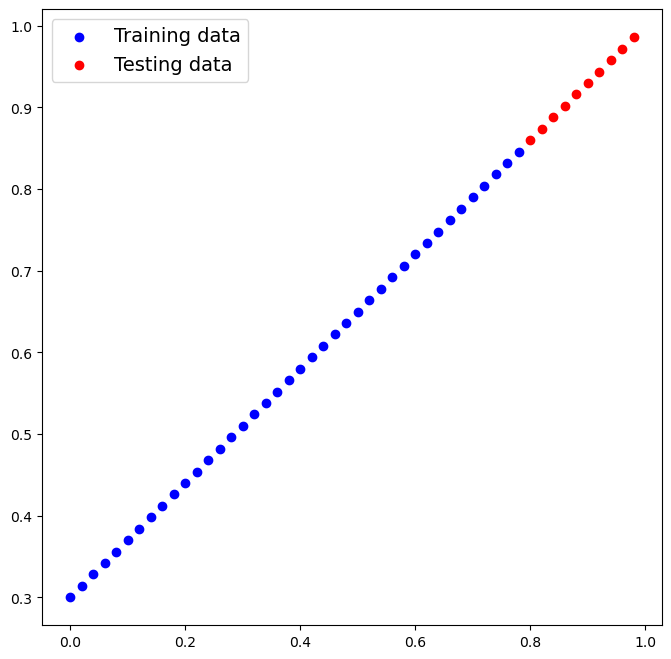

In [5]:
plot_preds()

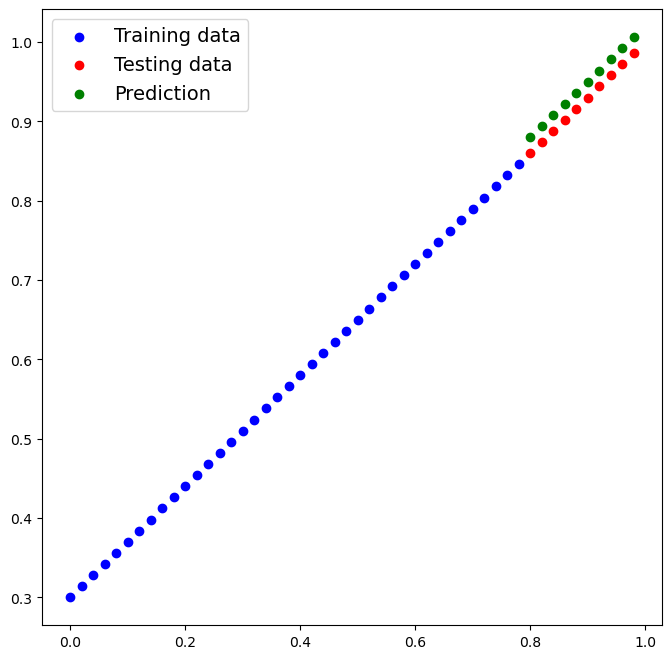

In [6]:
# testing a visualization for sample prediction
# plot_preds(preds=y_test+abs(torch.randn(y_test.size())))
plot_preds(preds=y_test+0.02)

### 2. Build a Model


In [7]:
# nn is a basic building block for pytorch graph and has 
# Containers
# Convolution Layers
# Pooling layers
# Padding Layers
# Non-linear Activations (weighted sum, nonlinearity)
# Normalization Layers
# Recurrent Layers
# Transformer Layers
# Linear Layers
# Dropout Layers
# Loss Functions
# etc

## nn.Module is a container, that is base class for all neural network models
class LinearRegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        # parameter size = 1, type = float, gradient required for possibility of future updates if needed in back propagation
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

# nn.Module requires a forward() method to be implemented
# for forward computations
    def forward(self,x:torch.Tensor):
        return self.weights*x+self.bias # a simple linear regression model
    


**Let's create an instance of the model to see the parameters that it holds with** ```.parameters()``` **method.**

In [8]:
torch.manual_seed(seed=42)

model_0 = LinearRegModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

**Let's see the state of the model with** ```.state_dict()``` **method.**

In [9]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

##### Let's make inference

In [10]:
# with torch.inference_mode()
with torch.no_grad(): 
    # Both are analogous, turns off bunch of things like gradient calculation which is needed in training but not in inference
    # Saves memory and computational time. It is a context manager and also can be used as decorator as @torch.no_grad() def inference(x): ....
    pred_0 = model_0(X_test)

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(pred_0)}")
print(f"Predicted values:\n{pred_0}")


Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


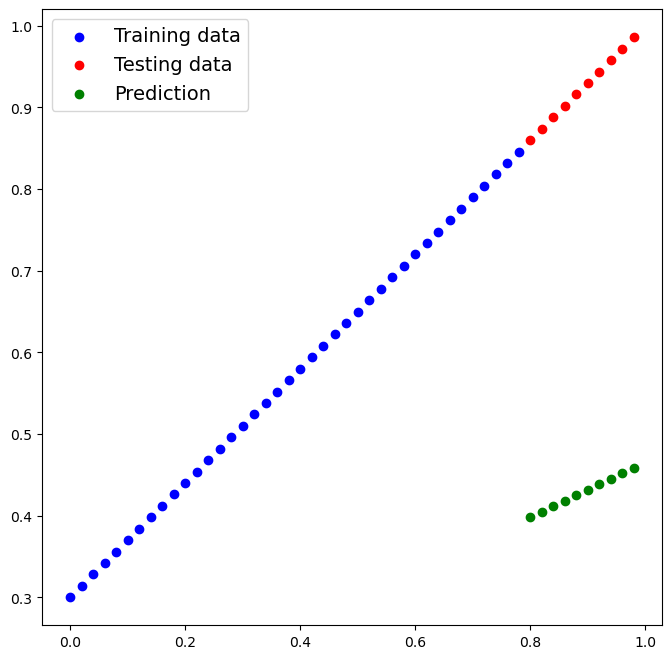

In [12]:
plot_preds(preds=pred_0)

In [13]:
y_test-pred_0

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

Till now, our model hasn't looked at the actual labels/outputs to be made. It just took a random values for weight and bias. We will be updating that.

### 3. Training Model

We will pass out model to calculate Loss i.e. the deviation of predicted values from actual values. The loss functions are in torch.nn. 

Also, we will need an optimizer, it tells our model how to update it's parameters. It is in torch.optim.

In [14]:
loss_fx = nn.L1Loss() # L1Loss is Mean Average Loss i.e. Average of all pred-actual

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)  # it takes parameters like parameters to be updated and learning rate, (momentum?) 

##### Training Loop

**1. Forward Pass** -> model(X_train)

**2. Calculate Loss** -> loss = loss_fn(y_pred,y_train)

**3. Zero Gradients** -> optimizer.zero_grad()

**4. BackPropagation on Loss** -> loss.backward()

**5. Update optimizer** -> optimizer.step()

##### Testing Loop

**1. Forward Pass** -> model(X_test)

**2. Calculate Loss** -> loss = loss_fn(y_pred,y_test)

**3. Evaluate (optional)** -> custom functions for evaluation metrics such as accuracy or other losses


In [15]:
torch.manual_seed(42)

epochs = 100
training_losses = []
testing_losses = []
epoch_count = []

for epoch in range(epochs):
    
    # put model in training mode (by default a model is in training mode)
    model_0.train()

###########################
    
    #Training Loop

###########################  
  
# Forward pass
    train_pred = model_0(X_train)

# Calculate loss
    train_loss = loss_fx(train_pred,y_train)

# Zero grad (clear the accumulated gradient)
    optimizer.zero_grad()

# Compute gradients and backward propagate them  
    train_loss.backward()

# update the parameters with propagated gradients
    optimizer.step()

###########################
    
    #Testing Loop

###########################


    # Put model in evaluation mode
    model_0.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model_0(X_test)

    # Loss calculation
        test_loss = loss_fx(test_pred,y_test)

     # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        training_losses.append(train_loss.detach().numpy())
        testing_losses.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | MAE Train Loss: {train_loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


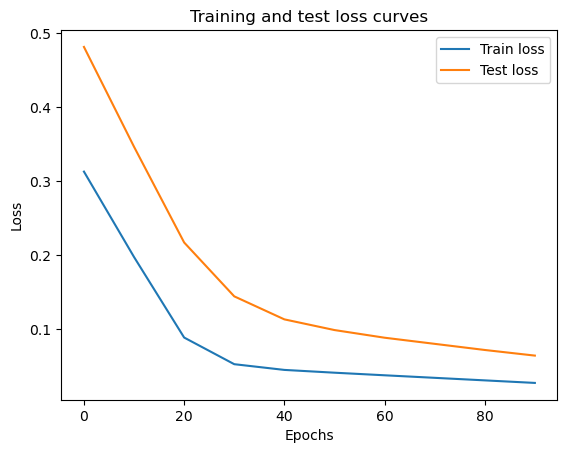

In [16]:
# Plotting Losses
plt.plot(epoch_count, training_losses, label="Train loss")
plt.plot(epoch_count, testing_losses, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 4. Making Inference

In [18]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

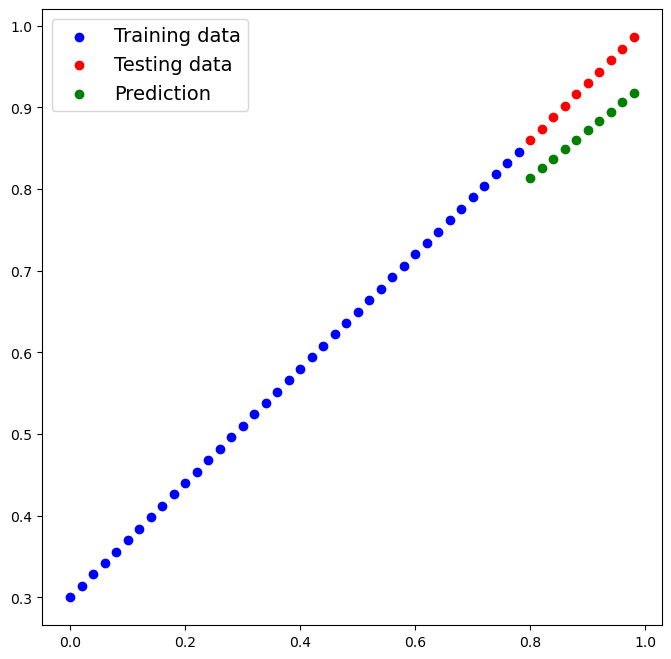

In [19]:
plot_preds(preds=y_preds)

### 5. Saving and loading a PyTorch model

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's ```state_dict()```.


In [20]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [21]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 contra contra 1207 Jul 10 07:14 models/01_pytorch_workflow_model_0.pth


Loading a saved PyTorch model's ```state_dict()```


In [22]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [24]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together

In [25]:
# skipped importing as it is already done above
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device is : {device}")

Device is : cuda


In [26]:
# Data creation and splitting skipped

In [57]:
# Making a model

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # using linear model for weights and biases
        self.linear = nn.Linear(in_features=1,out_features=1)

    def forward(self,x):
        return self.linear(x)
    
torch.manual_seed(seed=42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()



(LinearRegressionModel(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear.weight', tensor([[0.7645]])),
              ('linear.bias', tensor([0.8300]))]))

In [58]:
next(model_1.parameters()).device

device(type='cpu')

In [59]:
# By default model is on cpu, let's change it to gpu
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [67]:
# Loss function creation and Optimizer already selected (skipped here)

torch.manual_seed(seed=42)

epochs = 10000
# Since model is in GPU, put data in GPU else error occurs
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# print(f"X_train device: {X_train.device}")

for epoch in range(epochs):
    # put model in training mode (by default a model is in training mode)
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fx(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()


    #### Testing Loop ####
    model_1.eval()

    # 1. Forward pass
    with torch.no_grad():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fx(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 100 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 200 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 300 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 400 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 500 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 600 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 700 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 800 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 900 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 1000 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 1100 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 1200 | Train loss: 0.5551779866218567 | Test loss: 0.5874471664428711
Epoch: 1300

In [68]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear.bias', tensor([0.8300], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [69]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds


tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]], device='cuda:0')

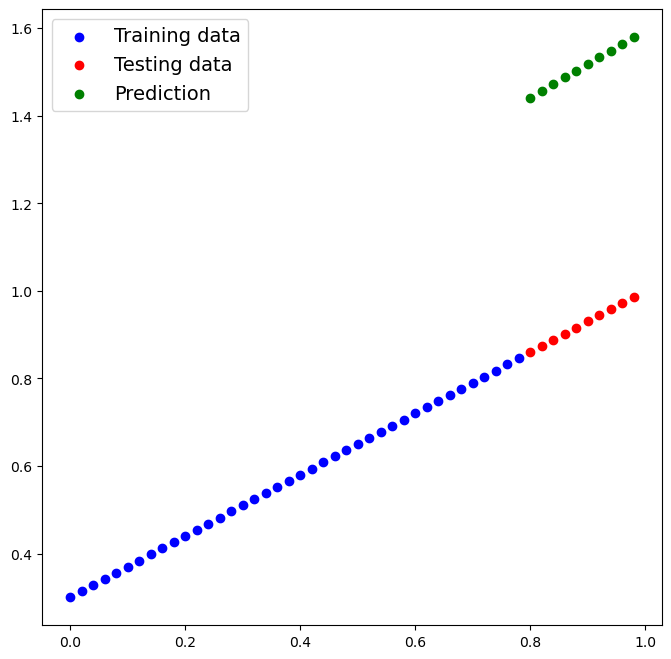

In [70]:
plot_preds(preds=y_preds.cpu())


In [34]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [35]:
# Instantiate a fresh instance of LinearRegressionModel
loaded_model_1 = LinearRegressionModel()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [36]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Completed